# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

Пусть $k_1 = 1, k_2 = 0$

In [2]:
objects = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
probabilities = np.bincount(objects) / len(objects)
-np.sum(list(map(lambda p: p * np.log(p), probabilities)))

0.5004024235381879

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def calc_jini(objects: list):
    probs = np.bincount(objects) / len(objects)
    return np.sum(list(map(lambda p: p * (1 - p), probs)))

Rl_objects = [1, 1, 1, 1, 1, 1, 1, 1]
Rr_objects = [0, 0]
Rm_objects = Rl_objects + Rr_objects

Rl = len(Rl_objects)
Rr = len(Rr_objects)
Rm = len(Rm_objects)

Q = calc_jini(Rm_objects) - Rl / Rm * calc_jini(Rl_objects) - Rr / Rm * calc_jini(Rr_objects)
Q = round(Q, 2)
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

В задаче регрессии предсказание в листе равно среднему значению целевой переменной для всех объектов в листе

In [4]:
targets = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
np.mean(targets)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Для подсчёта критерия информативности буду использовать эту формулку, потому что она оптимальнее:
$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) → \min_{j, t}
$$

In [6]:
# Хаотичность для задачи классификации
def calc_jini(objects: List):
    if len(objects) == 0:
        raise ValueError('objects list cant be empty')

    probs = np.bincount(objects) / len(objects)
    return np.sum(list(map(lambda p: p * (1 - p),probs)))

In [7]:
# Хаотичность для задачи регрессии
def calc_dispersion(objects: List):
    if len(objects) == 0:
        raise ValueError('objects list cant be empty')

    mean = np.sum(objects) / len(objects)
    return np.sum(list(map(lambda item: item - mean, objects))) / len(objects)

In [8]:
# Критерий информативности
def calc_informative_criterion(
    left_child_variance: float,
    right_child_variance: float,
    left_child_size: int,
    right_child_size: int,
) -> float:
    if left_child_size == 0 and right_child_size == 0:
        raise ValueError('children sizes cant be zero')

    parent_size = left_child_size + right_child_size

    return left_child_variance * left_child_size / parent_size + right_child_variance * right_child_size / parent_size

In [10]:
# Сплитуем по индексу
def calc_node_split(
    parent_objects: Union[np.ndarray, pd.DataFrame],
    threshold: int
) -> Tuple[list, list]:

    left_child: np.ndarray = parent_objects[:threshold]
    right_child: np.ndarray = parent_objects[threshold:]

    return list(left_child), list(right_child)

In [25]:
# Обрабатываем наше разбиение
def process_split(
        index: int,
        data: pd.DataFrame,
        thresholds: List[int],
        criterions: List,
        feature_type: str,
        task: str
):
    # создаем разбиение
    left, right = calc_node_split(data['target'], index)

    # проверка, что дети непустые
    if left and right:

        if feature_type == 'real':
            # если признак вещественный, то берем среднее соседей
            current_threshold = np.mean([data['feature'][index - 1], data['feature'][index]])
        else:
            # иначе - первое значение в правом листе
            current_threshold = data['feature'][index]

        # Считаем хаотичность детей. Так как в случае задачи регрессии
        # для категориальных признаков мы не можем посчитать дисперсию,
        # то будем считать коэффициент Джини
        if task == 'classification' or feature_type == 'categorical':
            variance_left = calc_jini(left)
            variance_right = calc_jini(right)
        else:
            variance_left = calc_dispersion(left)
            variance_right = calc_dispersion(right)

        # считаем критерий информативности для детей
        informative_criterion = calc_informative_criterion(
            left_child_variance=variance_left,
            right_child_variance=variance_right,
            left_child_size=len(left),
            right_child_size=len(right)
        )

        criterions.append(informative_criterion)
        thresholds.append(current_threshold)

In [31]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    if task != 'classification' and task != 'regression':
        raise ValueError('task can be either classification or regresion')

    thresholds = []
    criterions = []

    data = pd.DataFrame(feature_vector, columns=['feature'])
    data['target'] = target_vector

    if feature_type == 'real':
        data.sort_values(by='feature')
    elif feature_type != 'categorical':
        raise ValueError('feature must be either real or categorical')

    lambda_function = lambda index: process_split(
        index=index,
        data=data,
        thresholds=thresholds,
        criterions=criterions,
        feature_type=feature_type,
        task=task
    )

    # векторизируем функцию
    vectorized_function = np.vectorize(lambda_function)

    vectorized_function(data['feature'].index)

    criterion_best = min(criterions)
    threshold_best = thresholds[criterions.index(criterion_best)]

    return thresholds, criterions, threshold_best, criterion_best


Эту функцию можно протестировать на датасете `California`.

In [32]:
from sklearn.datasets import fetch_california_housing

In [33]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


В датасете 20к объектов, сплит идет примерно 2 минуты...

In [35]:
thresholds, criterions, threshold_best, criterion_best = find_best_split(
    X['MedInc'].to_numpy(),
    y,
    task='regression',
    feature_type='real'
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

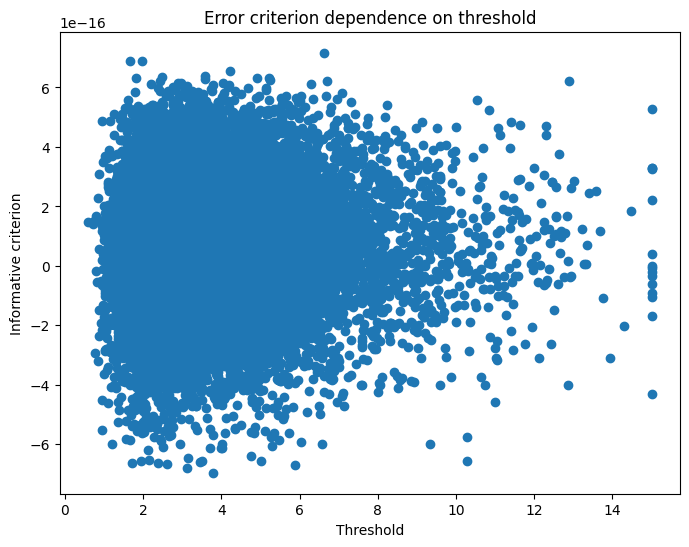

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(thresholds, criterions)

plt.title('Error criterion dependence on threshold')
plt.xlabel('Threshold')
plt.ylabel('Informative criterion');

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [1]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = np.argwhere(sub_X <= threshold_best) # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = np.argwhere(sub_X == threshold_best) # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    # структура словаря node:
    # type - листовая (terminal) или нелистовая (nonterminal) вершина
    # class - класс листовой вершины
    # feature_split - признак, по которому сплитуем
    # threshold - порог сплита в случае вещественного признака
    # category_split - категориальный признак по которому делаем сплит, если feature_split категориальный
    # left_child, right_child - дети

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        # буду делать рекурсивный обход дерева в глубину
        if not node:
            raise ValueError('node cant be None or empty')

        if node['type'] == 'terminal':
            return node['class']

        elif self._feature_types[node['feature_split']] == 'real':
            if x[node['feature_split']] <= node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        else:
            if not x[node['category_split']]:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [123]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [124]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

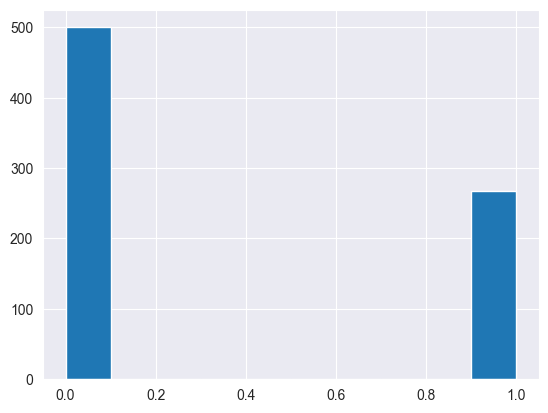

In [126]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [127]:
Y = data['Outcome']
X = data.drop('Outcome', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

X_train_train, X_train_validate, Y_train_train, Y_train_validate = train_test_split(X_train, Y_train, test_size=0.3, random_state=10)

print(f'training part: {round(X_train_train.shape[0] / X.shape[0], 2)}')
print(f'validation part: {round(X_train_validate.shape[0] / X.shape[0], 2)}')
print(f'test part: {round(X_test.shape[0] / X.shape[0], 2)}')

training part: 0.49
validation part: 0.21
test part: 0.3


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [128]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [129]:
max_depths = [1, 2, 3, 5, 7, 10]
min_samples_leafs = [1, 3, 5, 7, 10, 15]

optimal_max_depth = None
optimal_min_samples_leaf = None

max_f1_score = None

for i, max_depth in enumerate(max_depths):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        classifier = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=10
        )
        classifier.fit(X_train_train, Y_train_train)

        current_f1_score = f1_score(Y_train_validate, classifier.predict(X_train_validate))

        if max_f1_score is None or current_f1_score > max_f1_score:
            max_f1_score = current_f1_score
            optimal_max_depth = max_depth
            optimal_min_samples_leaf = min_samples_leaf

print(f"optimal max depth {optimal_max_depth}")
print(f"optimal min samples leaf {optimal_min_samples_leaf}")

optimal max depth 7
optimal min samples leaf 15


In [131]:
dt_classifier = DecisionTreeClassifier(
    max_depth=optimal_max_depth,
    min_samples_leaf=optimal_min_samples_leaf,
    random_state=10
)
dt_classifier.fit(X_train, Y_train)

dt_prediction = dt_classifier.predict(X_test)

print(f'accuracy {round(accuracy_score(Y_test, dt_prediction), 3)}')
print(f'precision {round(precision_score(Y_test, dt_prediction), 3)}')
print(f'recall {round(recall_score(Y_test, dt_prediction), 3)}')
print(f'auc_roc {round(roc_auc_score(Y_test, dt_prediction), 3)}')

accuracy 0.723
precision 0.646
recall 0.586
auc_roc 0.696


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [132]:
from sklearn.ensemble import BaggingClassifier

In [135]:
bag_classifier = BaggingClassifier(
    n_estimators=50,
    n_jobs=4,
    random_state=10
)
bag_classifier.fit(X_train, Y_train);

In [136]:
bag_prediction = bag_classifier.predict(X_test)

print(f'accuracy {round(accuracy_score(Y_test, bag_prediction), 3)}')
print(f'precision {round(precision_score(Y_test, bag_prediction), 3)}')
print(f'recall {round(recall_score(Y_test, bag_prediction), 3)}')
print(f'auc_roc {round(roc_auc_score(Y_test, bag_prediction), 3)}')

accuracy 0.771
precision 0.793
recall 0.529
auc_roc 0.723


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [138]:
max_depths = [1, 2, 3, 5, 7, 10, 15, 20]
min_samples_leafs = [1, 3, 5, 7, 10, 15]

optimal_max_depth = None
optimal_min_samples_leaf = None

max_f1_score = None

for i, max_depth in enumerate(max_depths):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        classifier = RandomForestClassifier(
            n_estimators=50,
            n_jobs=4,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=10
        )

        f1_scores = cross_val_score(
            estimator=classifier,
            X=X_train,
            y=Y_train,
            cv=5,
            scoring=make_scorer(f1_score)
        )
        mean_f1_score = f1_scores.mean()

        if max_f1_score is None or mean_f1_score > max_f1_score:
            max_f1_score = mean_f1_score
            optimal_max_depth = max_depth
            optimal_min_samples_leaf = min_samples_leaf

print(f"optimal max depth {optimal_max_depth}")
print(f"optimal min samples leaf {optimal_min_samples_leaf}")

optimal max depth 7
optimal min samples leaf 1


In [140]:
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    n_jobs=4,
    max_depth=optimal_max_depth,
    min_samples_leaf=optimal_min_samples_leaf,
    random_state=10
)

rf_classifier.fit(X_train, Y_train);

In [141]:
rf_prediction = rf_classifier.predict(X_test)

print(f'accuracy {round(accuracy_score(Y_test, rf_prediction), 3)}')
print(f'precision {round(precision_score(Y_test, rf_prediction), 3)}')
print(f'recall {round(recall_score(Y_test, rf_prediction), 3)}')
print(f'auc_roc {round(roc_auc_score(Y_test, rf_prediction), 3)}')

accuracy 0.74
precision 0.765
recall 0.448
auc_roc 0.682


Для удобства оценивания сведем все вместе:

In [142]:
print('Decision Tree scores:')
print(f'accuracy {round(accuracy_score(Y_test, dt_prediction), 3)}')
print(f'precision {round(precision_score(Y_test, dt_prediction), 3)}')
print(f'recall {round(recall_score(Y_test, dt_prediction), 3)}')
print(f'auc_roc {round(roc_auc_score(Y_test, dt_prediction), 3)}')

print()
print('Bagging:')
print(f'accuracy {round(accuracy_score(Y_test, bag_prediction), 3)}')
print(f'precision {round(precision_score(Y_test, bag_prediction), 3)}')
print(f'recall {round(recall_score(Y_test, bag_prediction), 3)}')
print(f'auc_roc {round(roc_auc_score(Y_test, bag_prediction), 3)}')

print()
print('Random Forest:')
print(f'accuracy {round(accuracy_score(Y_test, rf_prediction), 3)}')
print(f'precision {round(precision_score(Y_test, rf_prediction), 3)}')
print(f'recall {round(recall_score(Y_test, rf_prediction), 3)}')
print(f'auc_roc {round(roc_auc_score(Y_test, rf_prediction), 3)}')

Decision Tree scores:
accuracy 0.723
precision 0.646
recall 0.586
auc_roc 0.696

Bagging:
accuracy 0.771
precision 0.793
recall 0.529
auc_roc 0.723

Random Forest:
accuracy 0.74
precision 0.765
recall 0.448
auc_roc 0.682


Стоит заметить, что доля отрицательного класса примерно 66% от всего датасета, поэтому $accuracy \in [0.66; 1]$, да и в целом анализировать accuracy из-за дисбаланса классов довольно сомнительно.

Вывод:
* мне кажется, что BaggingClassifier лучше всего показал себя, потому что у него самые высокие precision и auc_roc, и при этом средний recall

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [143]:
n_estimators = np.arange(start=1, stop=100, step=1)
auc_roc_scores = []

for n in n_estimators:
    random_forest_class = RandomForestClassifier(
        n_estimators=n,
        n_jobs=4,
        max_depth=7,
        min_samples_leaf=1,
        random_state=10
    )
    random_forest_class.fit(X_train, Y_train)
    auc_roc_scores.append(roc_auc_score(Y_test, random_forest_class.predict(X_test)))

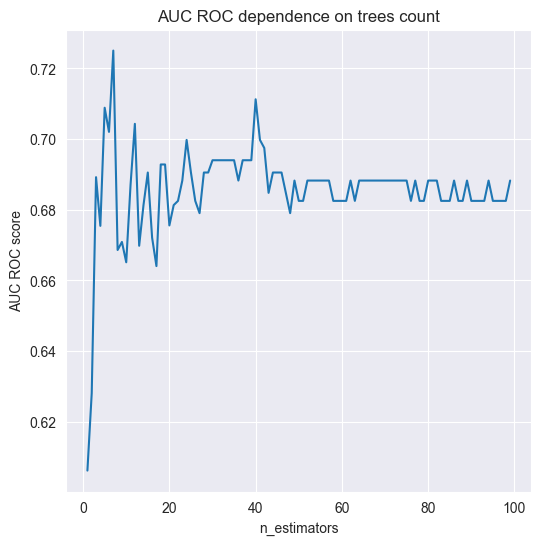

In [144]:
plt.figure(figsize=(6, 6))
plt.plot(n_estimators, auc_roc_scores)
plt.title('AUC ROC dependence on trees count')
plt.xlabel('n_estimators')
plt.ylabel('AUC ROC score');

Выводы:
1) Самый заметный факт - это то, что примерно после 50 деревьев AUC ROC случайного леса перестает сильно изменяться и по сути выходит на плато. То есть можно сказать, что случайный лес не переобучается с увеличением количества деревьев
2) Судя по графику, самое лучшее количество деревьев для этого датасета - примерно 5-7.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [145]:
from sklearn.inspection import permutation_importance

In [146]:
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    n_jobs=4,
    max_depth=optimal_max_depth,
    min_samples_leaf=optimal_min_samples_leaf,
    random_state=10
)
rf_classifier.fit(X_train, Y_train);

In [147]:
feature_importance = permutation_importance(
    estimator=rf_classifier,
    X=X_test,
    y=Y_test,
    n_repeats=10,
    random_state=10,
    n_jobs=4
)
random_forest_importances = pd.Series(data=feature_importance['importances_mean'], index=X_test.columns)
random_forest_importances

Pregnancies                -0.001299
Glucose                     0.093506
BloodPressure               0.006061
SkinThickness              -0.006926
Insulin                    -0.008658
BMI                         0.038961
DiabetesPedigreeFunction   -0.004329
Age                         0.010823
dtype: float64

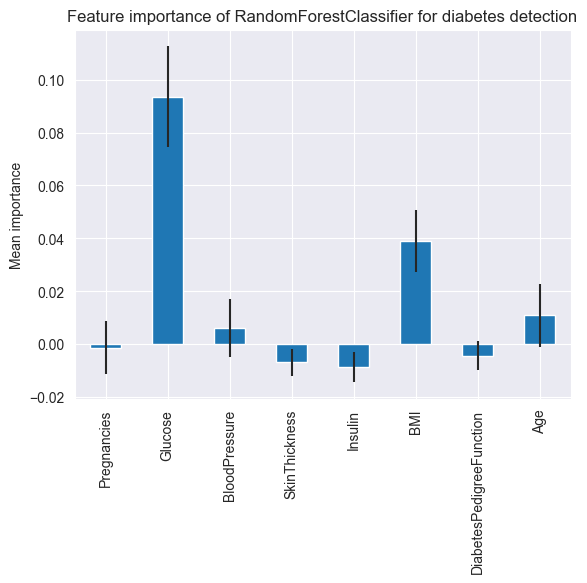

In [148]:
figure, ax = plt.subplots()
random_forest_importances.plot.bar(yerr=feature_importance['importances_std'], ax=ax)

ax.set_title('Feature importance of RandomForestClassifier for diabetes detection')
ax.set_ylabel('Mean importance');

Вывод:
Нетрудно заметить, что содержание глюкозы в крови является самым важным признаком для определения диабета. Также высокую значимость имеет индекс массы тела (BMI).